# **Machine Learning: Project Part 2**

---

**Author: Damien Farrell**

---

## **Project Part 2: Seal Call Discrimination**

### **Objective**
The aim of this project is to analyze a recorded dataset to investigate the feasibility of discriminating between different seal calls. The project is structured in steps to build a machine learning model that can potentially detect seal calls from audio recordings. While creating a fully functional detector is the ultimate goal, it may not be the final outcome of this project.

#### **Step A: Data Pre-processing**

This step is completed in notebook `data_preprocessing.ipynb`. The file `processed_data.pkl` was produced from this notebook.

#### **Step B: Model Training**
1. **Dataset Utilisation**:
   - Use the prepared spectrogram dataset to train the machine learning model.

3. **Evaluation**:
   - Test the model’s performance on a separate test dataset.

#### **Step C: Refine**
1. **Parameter Tuning**:
   - Adjust parameters in the data extraction/spectrogram creation process (e.g., `nfft`, `noverlap`).
   - Manage computational costs by splitting `.wav` files using tools like `pydub`.

2. **Validation**:
   - Apply the Rupe B/No Call classifier on an entire `.wav` file (held back during training).
   - Ensure no false positives due to the presence of other annotated calls.

In [503]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, regularizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import h5py
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K



---

### **Step B: Model Training** 

---

In [504]:
# Load in processed data
df = pd.read_pickle('processed_data.pkl')
df.head()

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),Annotation,file_name,folder_name,snippet_spectrogram,snippet_times,snippet_frequencies
0,1,Spectrogram 1,1,4.136987,4.657535,173.956,286.792,0.5205,112.836,-82.85,G Rupe,5711.211013040024,Guttural rupe,"[[10.569122314453125, 4.712647438049316, 1.273...","[4.131708333333333, 4.1445, 4.157291666666667,...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
1,2,Spectrogram 1,1,3.789955,4.264841,371.419,451.345,0.4749,79.926,-92.16,G Rupe,5711.211013040024,Guttural rupe,"[[42.39829635620117, 55.68126678466797, 83.361...","[3.7863333333333333, 3.799125, 3.8119166666666...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
2,3,Spectrogram 1,1,14.840188,15.406398,136.660,445.248,0.5662,308.588,-88.96,G Rupe,5711.211013040024,Guttural rupe,"[[29.341825485229492, 8.032623291015625, 43.69...","[14.838333333333333, 14.851125, 14.86391666666...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
3,4,Spectrogram 1,1,24.543802,25.082615,167.519,392.347,0.5388,224.828,-86.10,G Rupe,5711.211013040024,Guttural rupe,"[[0.28541040420532227, 0.41072168946266174, 2....","[24.547208333333334, 24.56, 24.572791666666667...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
4,5,Spectrogram 1,1,35.989220,36.573694,119.027,436.431,0.5845,317.405,-80.18,G Rupe,5711.211013040024,Guttural rupe,"[[13.951732635498047, 23.50061798095703, 20.28...","[35.982958333333336, 35.99575, 36.008541666666...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."


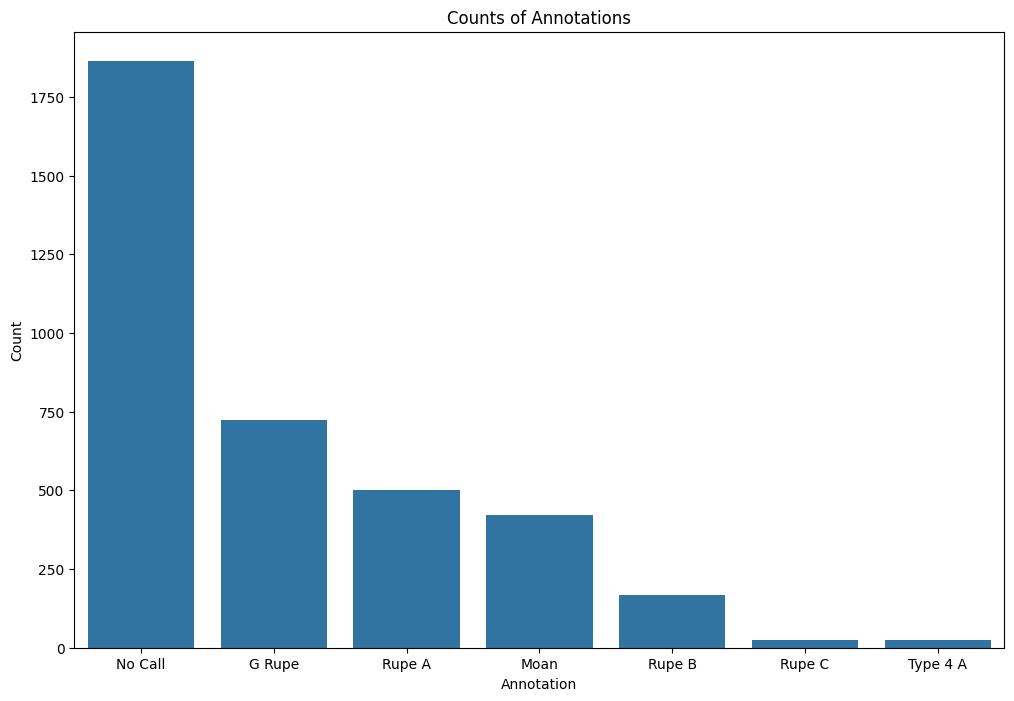

In [505]:
# Count the values
annotation_counts = df['Annotation'].value_counts()

# Create the barplot
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=annotation_counts.index, y=annotation_counts.values, ax=ax)

ax.set_xlabel("Annotation")
ax.set_ylabel("Count")
ax.set_title("Counts of Annotations")
plt.show()

In [506]:
# Perform one-hot encoding
df = pd.get_dummies(df, columns=['Annotation'], prefix='Annotation')

In [507]:
# Get the shapes
shapes = df['snippet_spectrogram'].apply(lambda x: x.shape if isinstance(x, np.ndarray) else None)

# Count unique shapes
print("Unique shapes in 'snippet_spectrogram':")
print(shapes.value_counts())

Unique shapes in 'snippet_spectrogram':
snippet_spectrogram
(42, 84)    3728
Name: count, dtype: int64


In [508]:
X = df[['snippet_spectrogram']].to_numpy()

# "Flatten" the (3742, 1) array to (3742,)
X = X.ravel()
print(X.shape)

# Stack along a new axis to get shape (3742, 42, 84)
X = np.stack(X, axis=0)
print(X.shape)


(3728,)
(3728, 42, 84)


In [509]:
# Reshape to 2D for MinMaxScaler
X_reshaped = X.reshape(-1, X.shape[-2])  # Shape: (3742 * 42, 84)

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_reshaped)

# Reshape back to the original shape
X = X_scaled.reshape(X.shape)

X.shape

(3728, 42, 84)

In [510]:
X = np.stack(df['snippet_spectrogram'].values)
y = df[[col for col in df.columns if col.startswith("Annotation_")]]  # Select annotation columns

# `y` contains one-hot encoded labels
stratify_labels = y.idxmax(axis=1)

# First split: Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=stratify_labels,
    shuffle=True
)

# Second split: Train/Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.25,
    random_state=42,
    stratify=y_train.idxmax(axis=1),
    shuffle=True
)

# Output shapes
train_shape = X_train.shape
val_shape = X_val.shape
test_shape = X_test.shape

train_shape, val_shape, test_shape

((2236, 42, 84), (746, 42, 84), (746, 42, 84))

In [511]:
stratify_labels

0        Annotation_G Rupe
1        Annotation_G Rupe
2        Annotation_G Rupe
3        Annotation_G Rupe
4        Annotation_G Rupe
               ...        
3723    Annotation_No Call
3724    Annotation_No Call
3725    Annotation_No Call
3726    Annotation_No Call
3727    Annotation_No Call
Length: 3728, dtype: object

#### **Model 1**

In [512]:
def plot_loss(history, which='loss'):
    plt.plot(history.history[which], label='train')
    try:
        plt.plot(history.history['val_' + which], label='Validation Loss')
    except:
        pass
    plt.xlabel('Epoch')
    plt.ylabel(which)
    plt.legend()
    plt.grid(True)

def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Accuracy')
    try:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    except:
        pass
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

In [513]:
input_shape = (42, 84, 1)
num_classes = len(stratify_labels.unique())

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=input_shape))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [514]:
model.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 42, 84, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 21, 42, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 21, 42, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 10, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 10, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 5, 10, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,927 (1.66 MB)

 Trainable params: 433,927 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [515]:
# Define focal loss
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = -y_true * alpha * K.pow(1 - y_pred, gamma) * K.log(y_pred)
        return K.mean(loss, axis=-1)
    return focal_loss_fixed

In [516]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss= focal_loss(gamma=2., alpha=0.25),  #from_logits=False as softmax is on the output of the CNN
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(thresholds=0.5, name="precision"),
        tf.keras.metrics.Recall(thresholds=0.5, name="recall"),
        tf.keras.metrics.AUC(multi_label=True, name="auc"),
        tf.keras.metrics.F1Score(threshold=0.5, average='macro', name="f1_score"),
    ]
)

In [517]:
# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [518]:
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[callback])

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6166 - auc: 0.6154 - f1_score: 0.1497 - loss: 0.0335 - precision: 0.7325 - recall: 0.2769 - val_accuracy: 0.7009 - val_auc: 0.8574 - val_f1_score: 0.2523 - val_loss: 0.0204 - val_precision: 0.9138 - val_recall: 0.4732
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7183 - auc: 0.8833 - f1_score: 0.2699 - loss: 0.0196 - precision: 0.8984 - recall: 0.5941 - val_accuracy: 0.7969 - val_auc: 0.8826 - val_f1_score: 0.3109 - val_loss: 0.0159 - val_precision: 0.9238 - val_recall: 0.6228
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7929 - auc: 0.8870 - f1_score: 0.3268 - loss: 0.0145 - precision: 0.9001 - recall: 0.6269 - val_accuracy: 0.8750 - val_auc: 0.8895 - val_f1_score: 0.4270 - val_loss: 0.0133 - val_precision: 0.9525 - val_recall: 0.7165
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8466 - auc: 0.9247 - f1_score: 0.4167 - loss: 0.0109 - precision: 0.9248 - recall: 0.7071

In [519]:
model.evaluate(X_test, y_test, return_dict=True)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9087 - auc: 0.8967 - f1_score: 0.5695 - loss: 0.0119 - precision: 0.9340 - recall: 0.8960


{'accuracy': 0.9235925078392029,
 'auc': 0.9375424385070801,
 'f1_score': 0.5950978994369507,
 'loss': 0.010850479826331139,
 'precision': 0.9403606057167053,
 'recall': 0.9088472127914429}

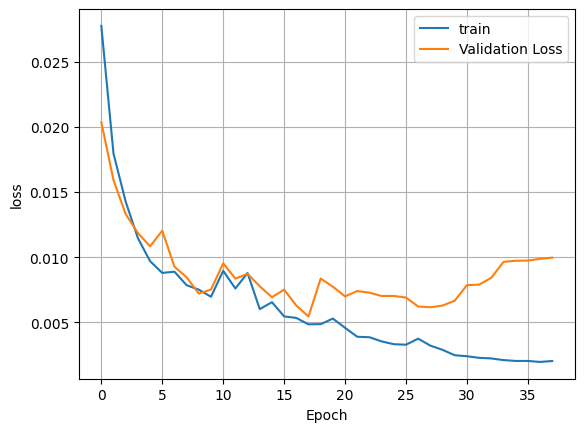

In [520]:
plot_loss(history)

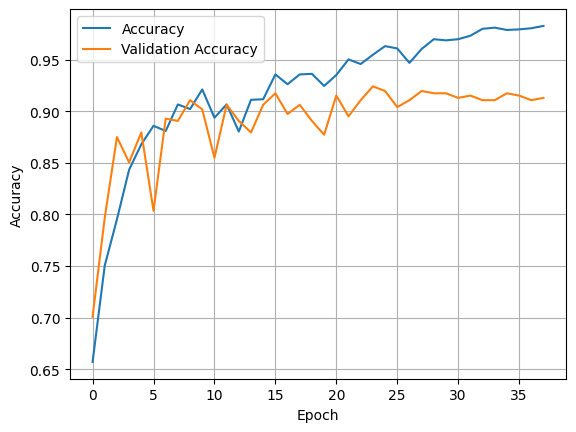

In [521]:
plot_accuracy(history)

In [522]:
def confusion_matrix_plot(): # Predict on test set
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Convert y_test one-hot to integers
    y_true = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true, y_pred)

    # Extract the real class names
    class_names = [col.replace("Annotation_", "") for col in y.columns]

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names,
                yticklabels=class_names,
                cmap="viridis", ax=ax)

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


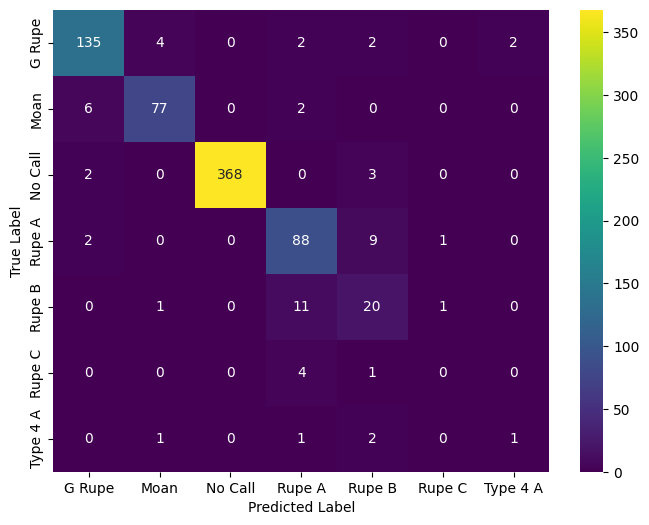

In [523]:
confusion_matrix_plot()

#### **Model 2**

In [524]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  # from_logits=False as softmax is on the output of the CNN
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(thresholds=0.5, name="precision"),
        tf.keras.metrics.Recall(thresholds=0.5, name="recall"),
        tf.keras.metrics.AUC(multi_label=True, name="auc"),  # Add AUC for multi-class classification
        tf.keras.metrics.F1Score(threshold=0.5, average='macro', name="f1_score"),
    ]
)

In [525]:
# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [526]:
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[callback])

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9690 - auc: 0.9541 - f1_score: 0.8103 - loss: 92.4158 - precision: 0.9767 - recall: 0.9647 - val_accuracy: 0.8951 - val_auc: 0.9340 - val_f1_score: 0.5859 - val_loss: 0.3743 - val_precision: 0.9144 - val_recall: 0.8817
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9650 - auc: 0.9806 - f1_score: 0.7192 - loss: 16.1608 - precision: 0.9722 - recall: 0.9539 - val_accuracy: 0.8996 - val_auc: 0.9492 - val_f1_score: 0.6209 - val_loss: 0.3579 - val_precision: 0.9182 - val_recall: 0.8772
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9655 - auc: 0.9590 - f1_score: 0.7817 - loss: 0.1258 - precision: 0.9797 - recall: 0.9539 - val_accuracy: 0.9286 - val_auc: 0.9388 - val_f1_score: 0.6178 - val_loss: 0.3337 - val_precision: 0.9379 - val_recall: 0.9107
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9708 - auc: 0.9623 - f1_score: 0.8412 - loss: 0.0893 - precision: 0.9778 - recall: 0.96

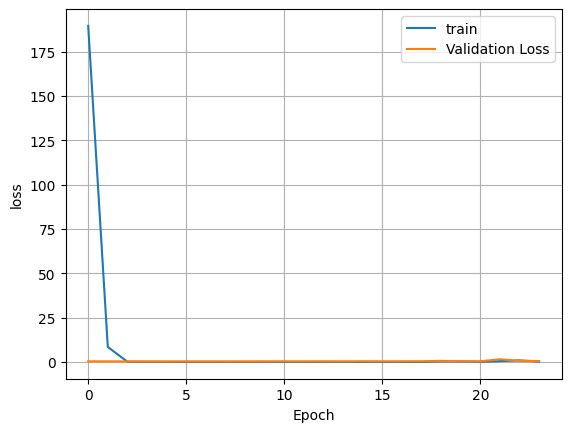

In [527]:
plot_loss(history)

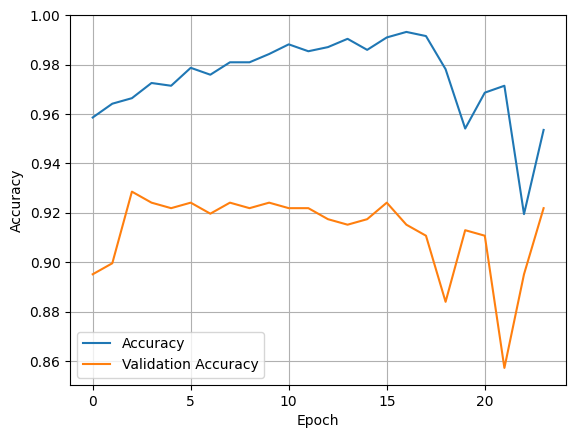

In [528]:
plot_accuracy(history)

In [529]:
model.evaluate(X_test, y_test, return_dict=True)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9173 - auc: 0.8600 - f1_score: 0.5920 - loss: 0.5757 - precision: 0.9232 - recall: 0.9135


{'accuracy': 0.930294930934906,
 'auc': 0.9149792790412903,
 'f1_score': 0.6139513254165649,
 'loss': 0.5047106742858887,
 'precision': 0.9362279772758484,
 'recall': 0.9249329566955566}

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


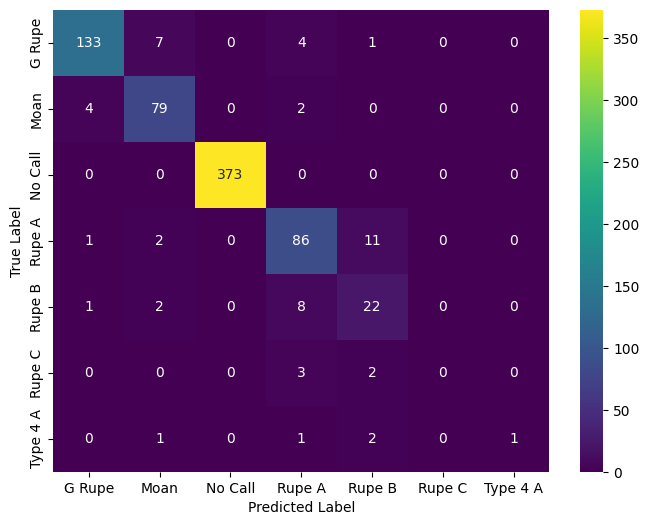

In [530]:
confusion_matrix_plot()

#### **Model 3: EfficientNet**

In [531]:
# Removed the data augmentation as the model is performing poorly.

# Training data generator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Validation data generator
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Test data generator
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [532]:
# Add a channel dimension
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [533]:
train_iterator = train_datagen.flow(X_train, y_train, batch_size=30, shuffle=True)
val_iterator = val_datagen.flow(X_val, y_val, batch_size=len(y_val), shuffle=True)
test_iterator = test_datagen.flow(X_test, y_test, batch_size=len(y_test), shuffle=True)

In [534]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

# Load the EfficientNetB4 base model
weights_path = 'noisy_student_efficientnet_b4.h5'

base_model = EfficientNetB4(
    weights=weights_path,
    include_top=False,
    pooling='avg',
)

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new custom top layers
model = keras.models.Sequential([
    base_model,                          # Add the base model
    #layers.Dropout(0.2),                 # Add Dropout
    layers.Dense(7, activation='softmax')  # Add custom Dense layer for classification
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(thresholds=0.5, name="precision"),
        tf.keras.metrics.Recall(thresholds=0.5, name="recall"),
        tf.keras.metrics.AUC(multi_label=True, name="auc"),
        tf.keras.metrics.F1Score(threshold=0.5, average='macro', name="f1_score"),
    ]
)

# Display the model architecture
model.summary()


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 1792)           │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 7)              │        12,551 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,686,374 (67.47 MB)

 Trainable params: 12,551 (49.03 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [535]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

callback_modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_EN.keras', monitor='val_loss', save_best_only=True)

In [536]:
history = model.fit(
    train_iterator,
    batch_size=32,
    epochs=20,
    validation_data=val_iterator,
    callbacks=[early_stop, callback_modelcheckpoint]
)

Epoch 1/50


c:\Users\Damien\ATU\machine-learning-project-2\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 166ms/step - accuracy: 0.0235 - auc: 0.4897 - f1_score: 0.0109 - loss: 4.2883 - precision: 0.0121 - recall: 0.0103 - val_accuracy: 0.0054 - val_auc: 0.4870 - val_f1_score: 0.0015 - val_loss: 3.3824 - val_precision: 0.0054 - val_recall: 0.0054
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.0346 - auc: 0.4725 - f1_score: 0.0038 - loss: 3.4304 - precision: 0.0052 - recall: 0.0041 - val_accuracy: 0.0054 - val_auc: 0.5076 - val_f1_score: 0.0016 - val_loss: 2.6384 - val_precision: 0.0057 - val_recall: 0.0054
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.0885 - auc: 0.4817 - f1_score: 0.0114 - loss: 2.7418 - precision: 0.0560 - recall: 0.0202 - val_accuracy: 0.0080 - val_auc: 0.4831 - val_f1_score: 0.0000e+00 - val_loss: 2.1533 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.2091 - auc: 0.4756 - f1_score: 0.0341 - loss: 2.3084 - precision: 0.3153 - recal

In [537]:
saved_model = load_model('best_model_EN.keras')

In [538]:
loss, accuracy = saved_model.evaluate(test_iterator)
print("Test Accuracy: ", accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.4946 - auc: 0.6043 - f1_score: 0.0015 - loss: 1.4439 - precision: 0.2857 - recall: 0.0027


ValueError: too many values to unpack (expected 2)

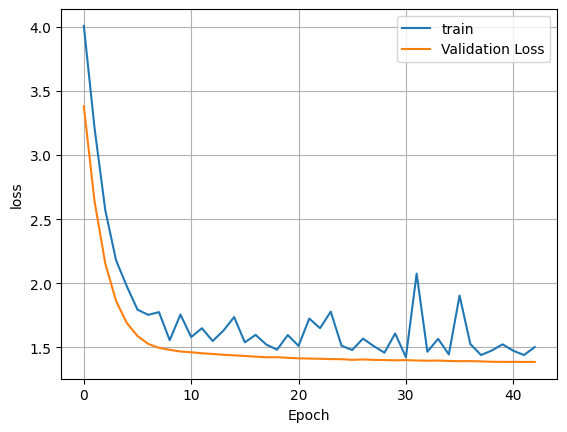

In [539]:
plot_loss(history)

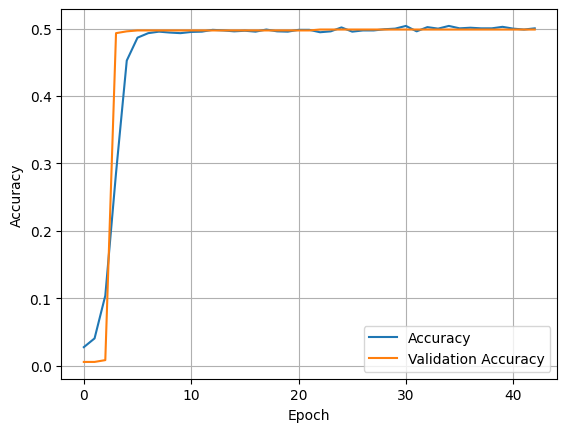

In [540]:
plot_accuracy(history)

24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step


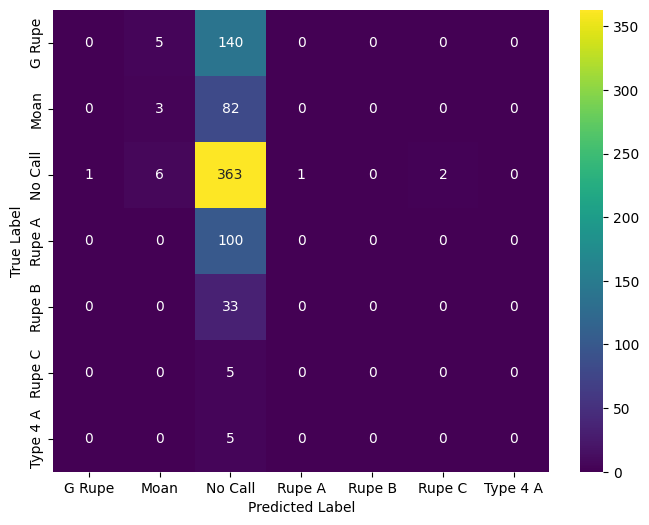

In [541]:
confusion_matrix_plot()

#### **Model 4**

---

### **Step C: Refine**

---

---

### **References**

1. [Bird Song Dataset on Kaggle](https://www.kaggle.com/code/sophiagnetneva/cnn-for-sound-classification-bird-calls-90)





---

# END